# RNSA Bone Age

In [1]:
import pandas as pd
import numpy as np

from os import listdir, mkdir, rename, makedirs
from os.path import isfile, join, isdir

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception, InceptionV3
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../rsna-bone-age/boneage-training-dataset.csv', index_col='id')
test = pd.read_csv('../rsna-bone-age/test.csv', index_col='id')

In [3]:
train.shape, test.shape

((12611, 2), (200, 2))

## Descriptives of dataset

In [4]:
train['gender'] = train.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
test['gender'] = test.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)

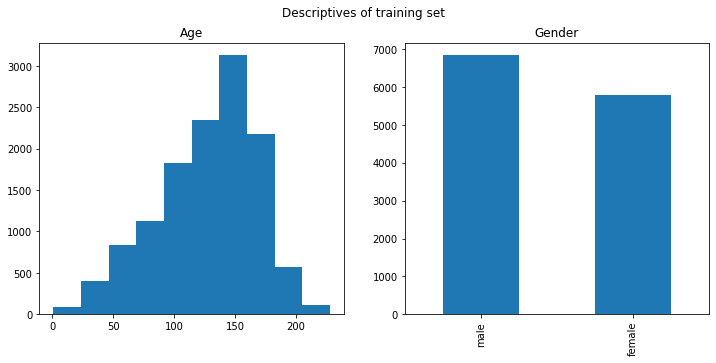

In [5]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of training set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
train['gender'].value_counts().plot(kind='bar', title='Gender');

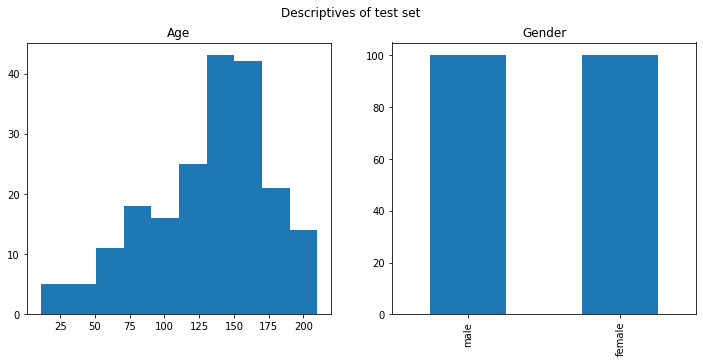

In [6]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of test set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(test['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
test['gender'].value_counts().plot(kind='bar', title='Gender');

## Add image path to df

In [7]:
def imgs_path(df, typ):
    """
    Function to add the image path to df
    """
    
    path = '../rsna-bone-age/boneage-{}-dataset/'.format(typ)
    df['img_path'] = None
    for img in listdir(path):
        if img.endswith('.png'):
            img_path = path + img 
            df.loc[(int(img.strip('.png'))), 'img_path'] = img_path
    return df

In [8]:
train = imgs_path(train, 'training')
test = imgs_path(test, 'test')

In [9]:
train.shape, test.shape

((12611, 4), (200, 4))

### Resizing and Padding
Code for the resize and padding function was taken from: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

In [10]:
import sys
import cv2

def resize_padding_img(img_path, desired_size):
    """
    Function to resize the image with padding
    """
    
    desired_size = desired_size
    im_pth = img_path

    im = cv2.imread(im_pth)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_im

def resize_padding_set(df, img_set, desired_size, save):
    """
    Function to resize the entire set of images with padding and save to a desired path
    """
    
    # Create directory for resized and padded images
    dirname = '../rsna-bone-age/resized_padded/{}'.format(img_set)
    if save:
        makedirs(dirname)
    
    # Create extra column in df to save path to resized and padded image
    df['rp_img_path'] = None
    
    for index, row in df.iterrows():
        # Resizing and padding
        img_path = row['img_path']
        if save:
            rp_img = resize_padding_img(img_path, desired_size)
        
        # Write resized and padded images to disk
        filename = '{}.jpg'.format(index)
        if save:    
            cv2.imwrite(dirname + '/' + filename, rp_img) 
        
        # Save path to resized and padded image to df
        df.loc[index, 'rp_img_path'] = filename
        
    return df

In [ ]:
train = resize_padding_set(train, 'training', 500, False)
test = resize_padding_set(test, 'test', 500, False)

In [ ]:
train.shape, test.shape

### Image Data Generator to prevent memory error

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='../rsna-bone-age/resized_padded_500/training',
    x_col='rp_img_path',
    y_col='boneage',
    target_size=(275,275),
    color_mode='rgb',
    class_mode='other',
    batch_size=64,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='../rsna-bone-age/resized_padded_500/training',
    x_col='rp_img_path',
    y_col='boneage',
    target_size=(275,275),
    color_mode='rgb',
    class_mode='other',
    batch_size=64,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='../rsna-bone-age/resized_padded_500/test',
    x_col='rp_img_path',
    y_col='boneage',
    target_size=(275,275),
    color_mode='rgb',
    class_mode='other',
    batch_size=200) # All images from test set in one batch

### Plot a few images in the training set

In [ ]:
def plot_images(generator):
    X, y = next(generator)
    fig, axes = plt.subplots(1, len(X[15:20]), figsize=(17, 5))
    for idx, ax in enumerate(axes):
        ax.axis('off')
        ax.imshow(X[idx][:,:,::-1])
        ax.set_title(y[idx], size=15, pad=10)

plot_images(train_generator)

In [ ]:
X_t, y_t = next(train_generator)

## Deep Learning
### Initial pre-trained Xception model

In [ ]:
def build_inception_model(dense_hidden_size=128,
                          l1_reg=0
                          l2_reg=0
                          dropout_rate=None, 
                          print_summary=True):
    
    # Instantiate InceptionV3 model trained on imagenet
    pre_trained_model = InceptionV3(weights='imagenet', include_top=False,
                                    input_shape=(X_t.shape[1], X_t.shape[2], X_t.shape[3]))
                                     
    # Freeze all layers 
    for layer in pre_trained_model.layers: 
        layer.trainable = False
        
    # Add a Global Average Pooling layer to reduce the number of parameters in the model
    pooling = layers.GlobalAveragePooling2D()(pre_trained_model.output)
    add_layer = pooling
    
    # Two dense hidden layers
    add_layer = Dense(dense_hidden_size, activation='relu',
                      kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(add_layer)
    if dropout_rate:
        add_layer = Dropout(dropout_rate)(add_layer)
        
    add_layer = Dense(dense_hidden_size, activation='relu',
                      kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(add_layer)
    if dropout_rate:
        add_layer = Dropout(dropout_rate)(add_layer)
    
    # Add output layer for regression
    output_layer = Dense(1, activation='linear')(add_layer)
    
    # Build new model structure
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)
    
    # Specify parameters for the adam optimizer
    optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=optim,
                  loss='mse',
                  metrics=['mae'])
    
    if print_summary:
        model.summary()
    
    return model

In [ ]:
model = build_inception_model()

In [18]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=20)

checkpointer = ModelCheckpoint(filepath='./models/keras_weights_{}.hdf5'.format(model.name),
                               monitor='val_mae',
                               save_best_only=True)

reduce_lr_on_plat = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.8, 
                                      patience=10, 
                                      verbose=1, 
                                      mode='auto', 
                                      epsilon=0.0001, 
                                      cooldown=5, 
                                      min_lr=0.0001)

callbacks = [early_stopping, checkpointer, reduce_lr_on_plat]

history = model.fit_generator(train_generator,
                              epochs=100,
                              validation_data=validation_generator, 
                              verbose=1, 
                              callbacks=callbacks)

/Users/myrthe/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/100
168/168 [==============================] - 2158s 13s/step - loss: 2568.7356 - mae: 38.6768 - val_loss: 2882.3816 - val_mae: 50.2556
Epoch 2/100
168/168 [==============================] - 2297s 14s/step - loss: 981.1073 - mae: 24.9287 - val_loss: 3596.8088 - val_mae: 45.5668
Epoch 3/100
168/168 [==============================] - 1925s 11s/step - loss: 808.3347 - mae: 22.6144 - val_loss: 2134.5808 - val_mae: 34.0908
Epoch 4/100
 29/168 [====>.........................] - ETA: 22:18 - loss: 735.6239 - mae: 21.2697

KeyboardInterrupt: 